<a href="https://colab.research.google.com/github/yeric1789/CMSC320_Final_Project/blob/main/NoteBookFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Tutorial on Multi-label Classification**
By Mads Andersen and Noah Cubert

## Table of contents
* A Tutorial on Multi-label Classification
  * Data Exploration
  * Data Preprocessing
  * Testing for normality and difference in distributions
  * Correlation between variables
  * Image Show-casing
* Predicting the label from images.
  * Cross validation
  * Data handling with Pytorch
  * Transforms of images
  * Visualize the data we will be training on
  * Defining the models
  * Loss, optimizer and scheduler
  * Model training
  * Model testing
  * Binary classification vs Multi-label classification
  * Finding the optimal threshold
  * Interpretations of the ROC curve
  * Testing
  * Accuracy as a metric for multilabel
  * Confusion matrix and F1-score
* Conclusions and final thoughts

## Introduction

In this tutorial you will be learning how to utilize deep learning techniques to do multi-label classification on the NIH Chest X-ray dataset (https://www.kaggle.com/nih-chest-xrays/data). We expect you to have a basic understanding of Python, statistics, linear algebra, and simple data handling techniques. You are expected to have a working Jupyter Notebook and/or Python environment for running code. We will be using the PyTorch library for our deep learning models.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.utils import resample
from scipy.stats import mannwhitneyu,shapiro

# Supress Warnings (For better readability of the notebook)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_style("darkgrid")# Setting style for seaborn

After downloading the dataset you should make a folder call images and place all the images from our dataset into the folder. Here we are utilizing our own GPU to run our code. If you are using a different environment you may need to change the code to run on your own GPU or CPU. 

In [ ]:
# check if google colab is exist
try:
    from google.colab import drive
    IN_COLAB = True
except Exception as e:
    IN_COLAB = False
    pass
# Load the data
if IN_COLAB:
    drive.mount('/content/drive')
else:
    print("Not in colab")

Not in colab


Now we want to load the labels for our data from the corresponding CSV file. Here we will sample 1500 images from the dataset and use 1000 of them for training and 500 for testing.

In [ ]:
# Change path to your data path in google drive or local path 
path_use = "/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/Data_Entry_2017.csv" if IN_COLAB else 'D:/CMSC320_XRAY_CHEST_DATA/Data_Entry_2017.csv'
data = pd.read_csv(path_use)

# We use a subset of the 38000 images feel free to change this number to use more or less data as needed
NUM_IMGS_READ = 30000
data_use = data.iloc[:NUM_IMGS_READ] 

# Randomly sample 1000 images
np.random.seed(0)
data = data_use.sample(n=1500, random_state=1)
data = data.reset_index(drop=True)

# data_test_sample =data_use.sample(n=1000, random_state=2)
# data_test_sample = data_test_sample.reset_index(drop=True)

# Display the data
display(data)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00002787_000.png,No Finding,0,2787,31,F,PA,2048,2500,0.171,0.171,NaN
1,00003289_001.png,No Finding,1,3289,42,M,PA,2992,2991,0.143,0.143,NaN
2,00007728_002.png,No Finding,2,7728,27,M,AP,2500,2048,0.171,0.171,NaN
3,00002339_003.png,No Finding,3,2339,55,F,PA,2992,2991,0.143,0.143,NaN
4,00005640_000.png,Consolidation,0,5640,39,M,PA,2992,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,00001429_001.png,Fibrosis|Pleural_Thickening,1,1429,59,F,PA,2518,2589,0.143,0.143,NaN
1496,00007408_000.png,Atelectasis|Pneumonia,0,7408,49,F,PA,2048,2500,0.168,0.168,NaN
1497,00006217_003.png,No Finding,3,6217,22,M,AP,2500,2048,0.171,0.171,NaN
1498,00004517_005.png,Pneumothorax,5,4517,63,M,AP,2500,2048,0.171,0.171,NaN


### Data Exploration 
Each observation has an image and some more attributes attached to it, we will start by exploring some of the attributes first. 

In [ ]:
data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,0.0
mean,7.400000,3917.576000,47.699333,2512.304000,2365.513333,0.161769,0.161769,NaN
std,12.677716,2268.387832,19.165015,315.101413,368.109115,0.013507,0.013507,NaN
min,0.000000,1.000000,4.000000,1700.000000,1365.000000,0.115000,0.115000,NaN
25%,0.000000,1909.750000,36.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,3868.000000,49.000000,2500.000000,2048.000000,0.168000,0.168000,NaN
75%,8.000000,5913.250000,59.000000,2575.000000,2544.000000,0.171000,0.171000,NaN
max,107.000000,7810.000000,412.000000,3056.000000,3056.000000,0.194311,0.194311,NaN


One thing to note is that the 'Finding Labels' column shows all the labels for each image seperating multiple labels with a pipe (|). We will need to split these labels up and create a new column for each label.
We assign the 'Finding Labels' column updated such that each value is a list of labels that are applicable to that image. Now lets look at the frequency of each label within our dataset.

In [ ]:
data['Finding Labels'] = data.apply(lambda x: x['Finding Labels'].split('|'),axis = 1)
# data_test_sample['Finding Labels'] = data_test_sample.apply(lambda x: x['Finding Labels'].split('|'),axis = 1)
# Count the different 
def overview_disease(data):
  overview = {}
  for findings in data['Finding Labels']:
    for j in findings:
      if j in overview.keys():
        overview[j] += 1
      else: 
        overview[j] = 1
  return overview
overview = overview_disease(data)
display(overview)


{'No Finding': 874,
 'Consolidation': 59,
 'Nodule': 71,
 'Pleural_Thickening': 46,
 'Pneumothorax': 58,
 'Effusion': 125,
 'Infiltration': 204,
 'Atelectasis': 136,
 'Cardiomegaly': 46,
 'Edema': 16,
 'Mass': 57,
 'Emphysema': 40,
 'Pneumonia': 18,
 'Fibrosis': 33,
 'Hernia': 5}

One thing to note about the frequency of our dataset is that the 'No Finding' label is the most common. This could cause some issues with our model as it will be more likely to predict 'No Finding' than any other label. We will take this into account when we train our model.

### Data Preprocessing
Now we can create a one-hot encoding dataframe of all the labels being assigned to each image. After that it can be concatenated with the originial data matrix.

In [ ]:
dummies = pd.DataFrame(np.zeros((len(data), len(overview.keys())), dtype=np.int), columns=overview.keys())
for i,des in enumerate(data['Finding Labels']):
  dummies.loc[i][des] = 1

# overview_samp = overview_disease(data_test_sample)
# dummies_samp = pd.DataFrame(np.zeros((len(data_test_sample), len(overview_samp.keys())), dtype=np.int), columns=overview_samp.keys())
# for i,des in enumerate(data_test_sample['Finding Labels']):
#   dummies_samp.loc[i][des] = 1

#Concat horizontally
data = pd.concat([data,dummies],axis=1)
display(data)

# #Concat horizontally
# data_test_sample = pd.concat([data_test_sample,dummies_samp],axis=1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Infiltration,Atelectasis,Cardiomegaly,Edema,Mass,Emphysema,Pneumonia,Fibrosis,Hernia
0,00002787_000.png,[No Finding],0,2787,31,F,PA,2048,2500,0.171,...,0,0,0,0,0,0,0,0,0,0
1,00003289_001.png,[No Finding],1,3289,42,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00007728_002.png,[No Finding],2,7728,27,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
3,00002339_003.png,[No Finding],3,2339,55,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
4,00005640_000.png,[Consolidation],0,5640,39,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,00001429_001.png,"[Fibrosis, Pleural_Thickening]",1,1429,59,F,PA,2518,2589,0.143,...,0,0,0,0,0,0,0,0,1,0
1496,00007408_000.png,"[Atelectasis, Pneumonia]",0,7408,49,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,1,0,0
1497,00006217_003.png,[No Finding],3,6217,22,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
1498,00004517_005.png,[Pneumothorax],5,4517,63,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0


Now let's see which diseases are the most common, by plotting a histogram. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'No Finding'),
  Text(1, 0, 'Consolidation'),
  Text(2, 0, 'Nodule'),
  Text(3, 0, 'Pleural_Thickening'),
  Text(4, 0, 'Pneumothorax'),
  Text(5, 0, 'Effusion'),
  Text(6, 0, 'Infiltration'),
  Text(7, 0, 'Atelectasis'),
  Text(8, 0, 'Cardiomegaly'),
  Text(9, 0, 'Edema'),
  Text(10, 0, 'Mass'),
  Text(11, 0, 'Emphysema'),
  Text(12, 0, 'Pneumonia'),
  Text(13, 0, 'Fibrosis'),
  Text(14, 0, 'Hernia')])

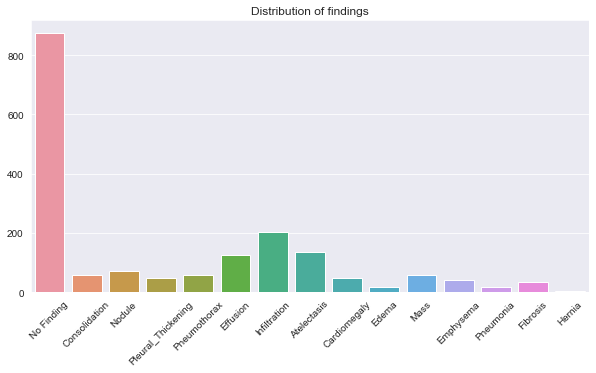

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
x = list(overview.keys())
y = list(overview.values())
sns.barplot(x,y)
plt.title('Distribution of findings')
plt.xticks(rotation=45)

As can be seen there is large class imbalance. Lets explore how the age distribution looks, by plotting the histogram of the patient age. 

Text(0.5, 1.0, 'Patient age')

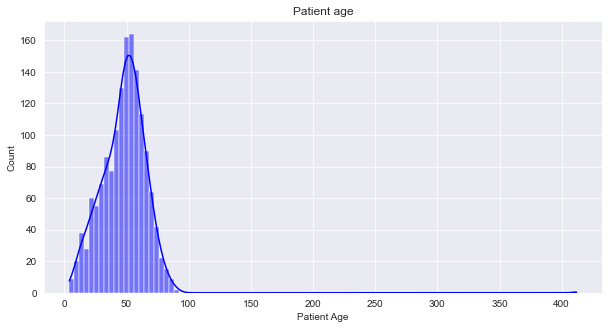

In [ ]:
sns.histplot(data = data,x = 'Patient Age',color = 'b',kde=True)
plt.title("Patient age")

Looks like some 400 year old mummy is in our dataset, For our purposes this is not a problem, but if we were to use this dataset for medical purposes we would need to remove this outlier.


Lets us also look for any bias problems in our datasets.  One way we could search for bais is by differentiating between genders. This could be important since we want to know if the model might have some sort of bias against age or gender. 

Text(0.5, 1.0, 'Patient age')

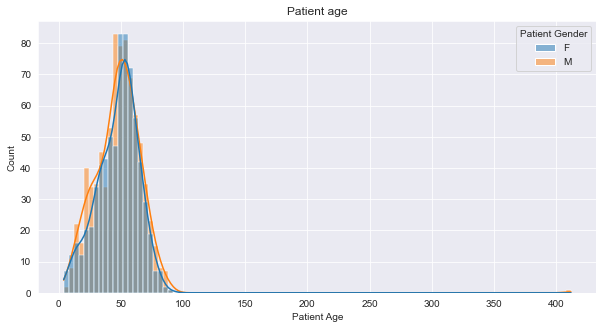

In [ ]:
sns.histplot(data = data,x = 'Patient Age', hue = 'Patient Gender',kde=True)
plt.title("Patient age")

The distributions look extremely similar so the bias with regards to gender seems to be minimal.


## Testing for normality and difference in distributions
We can vizualize if gender has an influence on how frequent a lung diseases occur. One thing we can interpret from the plots is that it looks like the Male group has a higher variance. However from the plot it is quite hard to tell.

Another thing is that it looks like female genders might might follow a normal distribution somewhat however for the males we are hesitant to make any conclusions. In order to decide we will perform The Shapiro-Wilk test which has a null hypothesis (H0): that the data was drawn from a normal distribution, the result of this test will then determine if we choose to use a parametric or non-paramtric test between the two groups. 



In [ ]:
gender_df = data.groupby('Patient Gender')
female, male = data[data['Patient Gender'] == 'F']['Patient Age'], data[data['Patient Gender'] == 'M']['Patient Age']
gender_df['Patient Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Patient Gender,,,,,,,,
F,704.0,47.53125,16.338059,4.0,36.0,50.0,59.0,91.0
M,796.0,47.84799,21.365010,4.0,35.0,49.0,59.0,412.0


In [ ]:
shapiro(female).pvalue

3.514670368076622e-07

In [ ]:
# The Shapiro-Wilk test
female_pval = shapiro(female).pvalue 
male_pval = shapiro(male).pvalue
string = f'p-value in test for normality \nFemale: {female_pval} \nMale: {male_pval}' 
print(string)

p-value in test for normality 
Female: 3.514670368076622e-07 
Male: 1.3914086940038445e-33


Since our p-values for both genders are less than 0.05 we can reject the null hypothesis and conclude that the data is not normally distributed. Because of this we will be using the The Mann-Whitney U test which is a non parametric test between distributions. The non-parametric is important here since it does not take any distribution into account. One reason we might not always want to use this is that it has lower statistical power, which means it will more often reject the null hypothesis when it should not. 

In [ ]:
# mannwhitneyu test
diff_pvalue = mannwhitneyu(male,female).pvalue
if diff_pvalue > 0.05:
    print(f'We fail to reject the null hypothesis with significance 0.05 and with p-value: {diff_pvalue}')
else:
    print(f'We reject the null hypothesis with significance 0.05 and with p-value: {diff_pvalue}')

We fail to reject the null hypothesis with significance 0.05 and with p-value: 0.7203603799877727


So from the Mann-Whitney U test, we can derive that there is not a significant difference between Male and Female ages for the diseases we are looking at. Do note that all of this has been computed on a subset of the real data-set and thus may not be representative for the entire data-set. 

## Correlation between variables

Now we can plot the correlation matrix, to check if any of the findings often occur together. Note that we have temporarily dropped *'No Finding'* label since it will never occur together with any of the other variables.

Text(0.5, 1.0, 'Correlation matrix of findings')

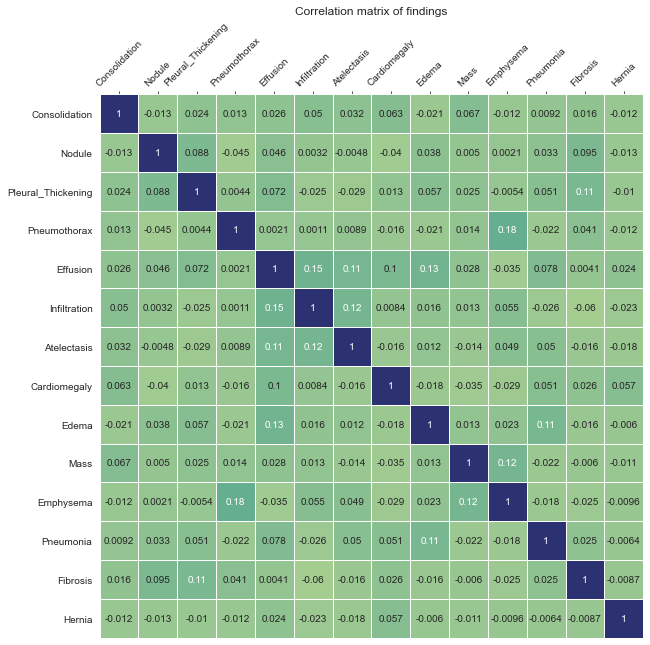

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
df = dummies.drop(columns = 'No Finding').corr()
ax = sns.heatmap(df,annot = True,cmap="crest",square=True, linewidths=.5,cbar=False)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=45)
plt.title('Correlation matrix of findings')

None of our datapoints seem to be highly correlated with each other. This is good since it means that our model will not be biased towards any of the labels.

## Image Show-casing

Now we can look at some of the images in our dataset. We will be using the matplotlib library to display the images.

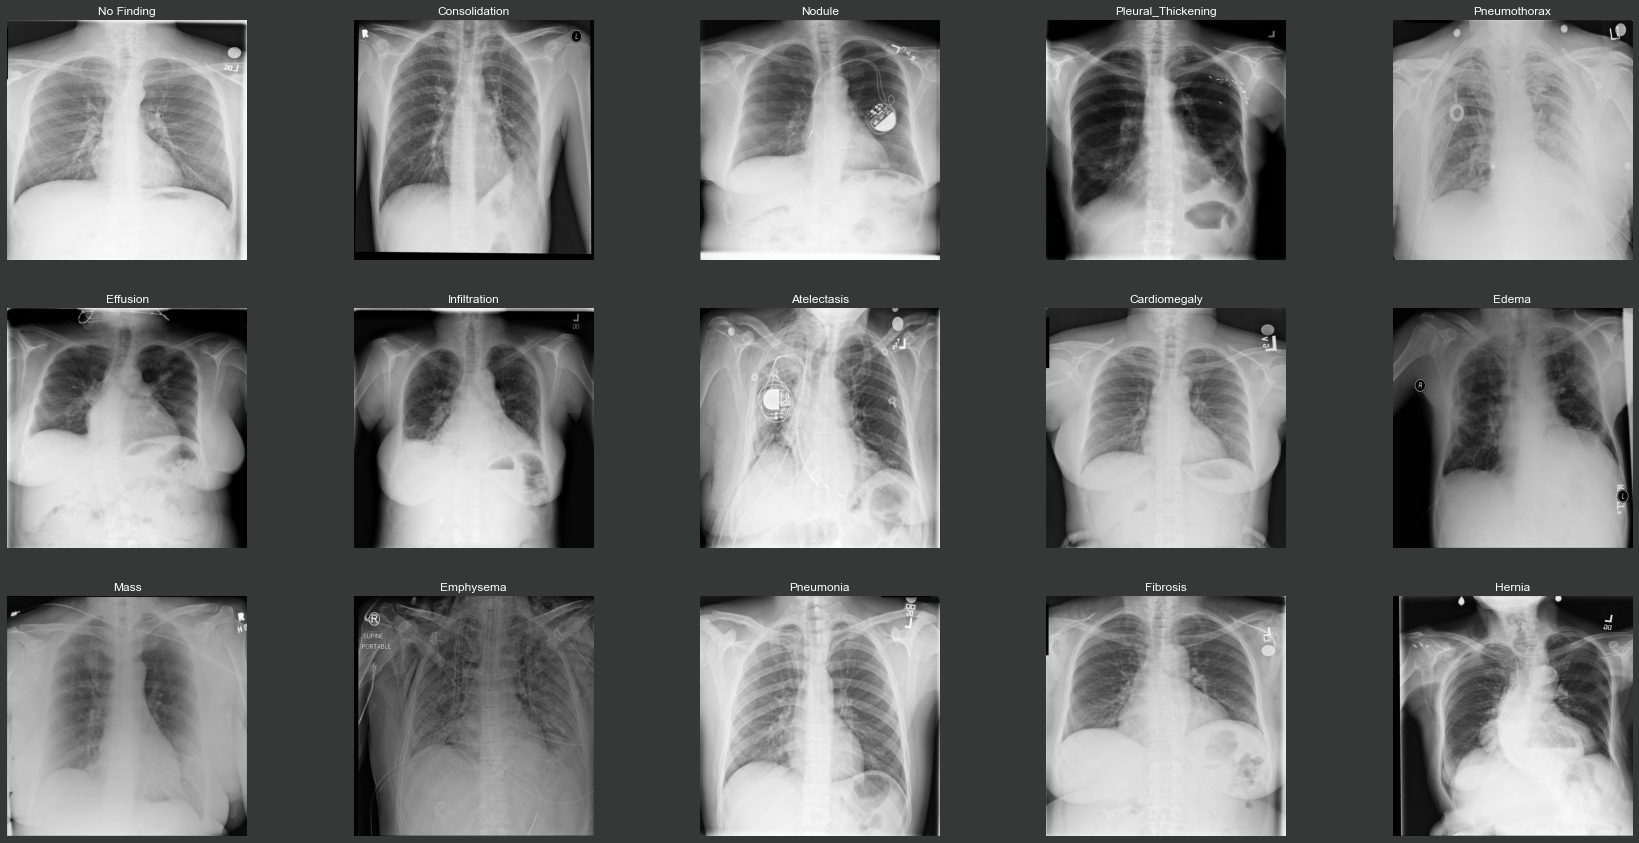

In [ ]:
# Plot the images
ht = 3
wd = 5
plt.rcParams["figure.figsize"] = (2*ht*wd,ht*wd)
plt.rcParams["axes.grid"] = False
# Change path to your data path in google drive or local path
imag_dir = '/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/images/' if IN_COLAB else 'D:/CMSC320_XRAY_CHEST_DATA/images/'
# 15 different labels

fig, ax = plt.subplots(ht,wd)
# Gray background
fig.patch.set_facecolor('xkcd:dark grey')
n_img = 0


# Get 
unique_labels = [str(i) for i in data.columns[12:]]
for i in range(ht):
    for j in range(wd):
        # Pop unique label to use
        label = unique_labels.pop(0)
        # Get sample one image from the set of images with the label
        sample = data[data[label] == 1].sample(n=1)
        path_img = imag_dir + sample.iloc[0]['Image Index']
        img = plt.imread(path_img)
        ax[i,j].imshow(img, cmap = 'gray')
        ax[i,j].set_title(label, color = 'white')
        # set color 
        ax[i,j].set_axis_off()
        n_img += 1

These are some of the images in our dataset. Each of the images above represent a different class of diseases. Note that some of these classes are not mutually exclusive, meaning that a patient can have more than one disease at the same time. Note there are some things in the images like wires and connectors that are not diseases and should not be classified as such. These could cause our training model some difficulties. 

# Predicting the label from images. 

First we have to do some imports, also we will be using torchmetrics, since it does not exist in Colab we have to use `!pip install torchmetrics` to install it

In [ ]:
if IN_COLAB:
    # do pip install in colab
    !pip install torchmetrics


In [ ]:
#Torch imports 
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch import nn
import torch.functional as F

#Image and CV handling
from PIL import Image
import os
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split

#The things below needs to be installed 
from torchmetrics.classification import Accuracy,F1Score,ConfusionMatrix,ROC
from torchviz import make_dot
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # use GPU if available
print(device)

cuda


## Cross validation 
First let us make sure that we make a trainning,validation and test set. The training and validation sets will be used during training. We will specifically train on train-set, and then to figure out when to stop training we run the model on our validation set for each epoch. Once we have stopped the training, we will do a final run on our test-set in order to asses, how well we can expect to generalize beyond the training data. We will also be using the results from that test set, to run our statistics on, so that we can end up with a final verdict on how well we did. 

Since we have random sampled from the image data-set, we don't need to worry about randomizing the splits. One thing we would like to point out is the stratification part. Ussually when working with classification one would stratify the splits, meaning that there would be and equal amount of each label class in the split. However we are working with multilabel classification, so stratification would almost be a torturial on it's own. We will accept this shortcomming for the sake of keeping complexity down in this torturial. 


In [ ]:
train_df = data[:1000] # 1000 images for training
val_df = data[1250:] # 250 images for validation
test_df = data[1000:1250] # 250 images for testing

overview = overview_disease(train_df) # Get the overview of the training set
relative_frequency = np.array(list(overview.values()))/sum(overview.values()) # Get the relative frequency of each label this will be used later for the loss function

# Convert to tensor
relative_frequency = torch.from_numpy(relative_frequency).float()

#train_df, test_df = train_test_split(data,test_size=0.15, random_state=42)

## Data handling with Pytorch

In order to work with pytorch and the image data, we have to create a costoum data-set. This is basically just a class, where you specify the __len__() and __getitem__() methods. Especially __getitem__() is important in this case, since we don't wan't to load all of the images into the ram at once. We are working with a big data-set and we can easily end up using all of the ram if we are not smart about how we do the loading of the data. 

The way we construct the data-set class is that each time the __getitem__() class is called it loads the image from the directory. This means that we only take images into the ram when we actually need them. 

Another thing we adress in this class is the construction of labels and transformations we apply to the images. We will be explaining two forms of classificatin binary and multi-label. The first method is quite a lot simpler than the second. 

### Binary
The way we can convert the problem to a binary problem is simply by only predicting if the image contains a finding or no finding, but not which specific finding that is being considered. 

### Multi-label 
Here we would actually try to predict which exact label to assign to given image.

The way this can be handled with pytorch is simply to create a binary variable indicating if we want to work with the binary data or the multi-label data. Notice how there is different if statements in the __getitem__() method. This allows us to only implement one class, instead of having to redefine the class. 

In [ ]:
class LungDataSet(Dataset):
  
  def __init__(self,df,root_dir,input_size,transform = None, binary = True, cuda_device = None):
    self.df = df 
    self.root_dir = root_dir
    self.transform = transform
    self.input_size = input_size
    self.binary = binary
    self.cuda_device = cuda_device

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    
    img_name = self.df.iloc[idx,0]
    path = os.path.join(self.root_dir,img_name)
    #print(path)

    image = io.imread(path)
    avg = np.mean(image)
    std = np.std(image)
    image = (image - avg)/std
    
    if len(image.shape) > 2: # For some reason some of the images have copied slices of them self so they are 3d 
      image = image[:,:,0]

    
    # Resize the image to the input size and add 3 channels
    image = torch.tensor([transform.resize(image, self.input_size) for i in range(3)]) 
    
    if self.binary:
      labels = self.df.iloc[idx,15] #12: if we use all labels
      labels = torch.tensor([1,0]) if labels.item() == 0 else torch.tensor([0,1]) # Notice how 0 in no finding means there is a finding
    else: 
      labels = self.df.iloc[idx,12:]
      labels = labels.to_list()
    
    labels = torch.tensor(labels).to(float)

    if self.transform:
      image  = self.transform(image)
    sample = {'image': image, 'labels': labels}
    #print("Type of sample['image']: ", sample['image'].shape)


    return sample 

### Transforms of images 
As we are using the Densenet architecture, we may risk overfitting the network to the images. In order to combat this we will be using transformations. The ones we will be using are random horizontal flips and random vertical flips. These transformations are basically just flipping the images in random directions, this is in the hope that the network will learn the representation of the actual illness and not be biased towards the direction of the image it is seeing. Furthermore the images will be resized to 299x299 to allow for faster training.

In [ ]:

IMG_SHAPE = (299,299)

# Data transforms Normalizing applied within LungDataSet __getitem__ method
test_tform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# 
train_tform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),

                                ])

dir = '/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/images/' if IN_COLAB else 'D:/CMSC320_XRAY_CHEST_DATA/images/'
train_set = LungDataSet(df = train_df,
                        root_dir = dir,
                        input_size = IMG_SHAPE,
                        transform = train_tform,
                        binary = False,
                        cuda_device=device)

val_set = LungDataSet(df = val_df,
                       root_dir = dir,
                       input_size = IMG_SHAPE,
                       transform = test_tform, #We will be using the same transform
                       binary = False,
                       cuda_device=device)

test_set = LungDataSet(df = test_df,
                       root_dir = dir,
                       input_size = IMG_SHAPE,
                       transform = test_tform,
                       binary = False,
                       cuda_device=device)

## Visualize the data we will be training on 

0 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
1 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
2 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
3 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


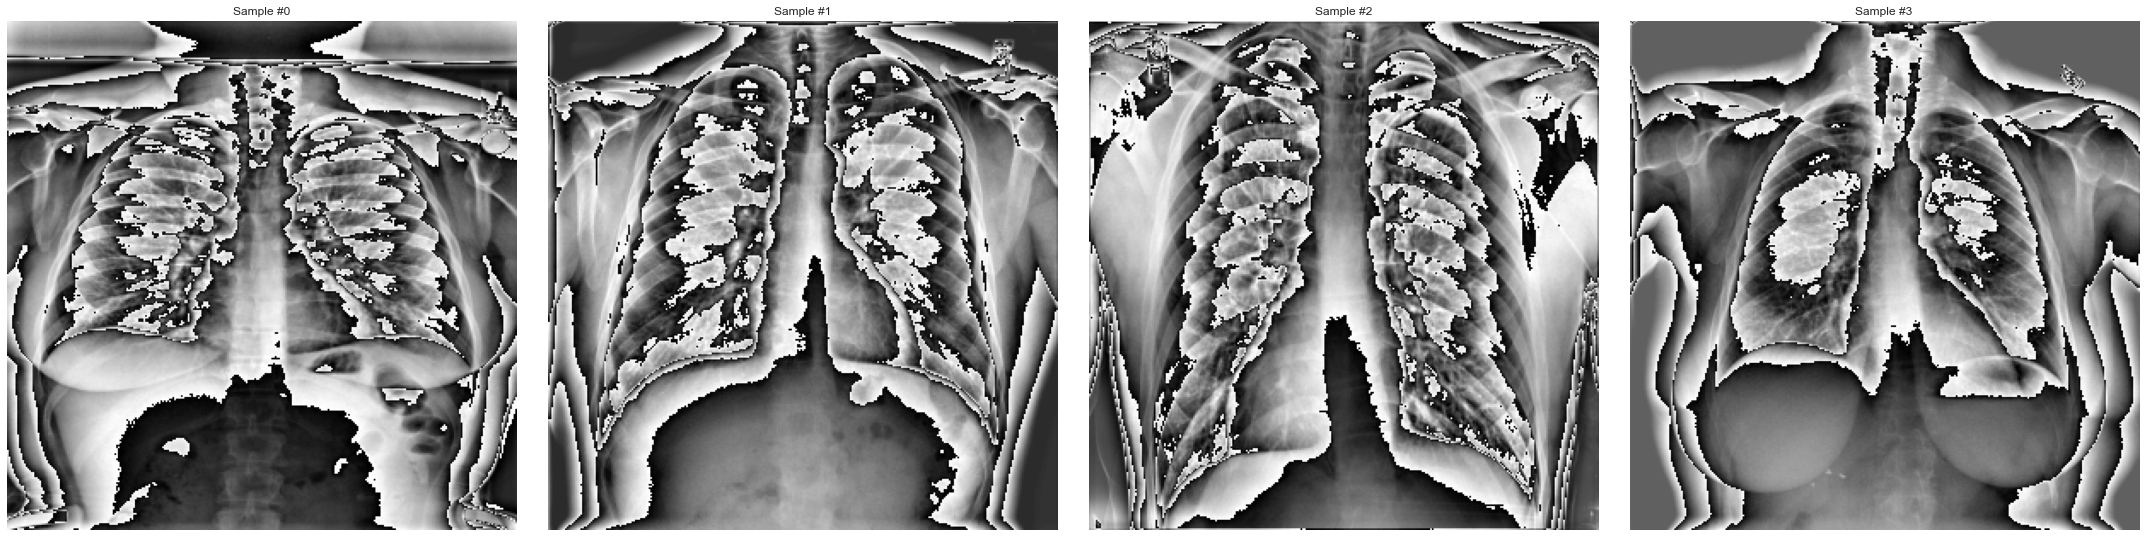

In [ ]:
def visualize(data):
    fig = plt.figure()
    for i in range(len(data)):
        sample = data[i]

        print(i, sample['image'].shape, sample['labels'])

        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        plt.imshow(sample['image'][0,:,:],cmap = 'gray')

        if i == 3:
            plt.show()
            break


visualize(train_set)

Notice above how the images are each normalized. This is done in order to make sure that the network does not get biased towards any specific intensity of a particular image. This is done by subtracting the mean and dividing by the standard deviation. You can find this tranformation in the LungDataSet __getitem__() method.

In [ ]:
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALD = 1
BATCH_SIZE_TEST = 1
#Train Loader 
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=0)

#Val Loader 
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE_VALD, shuffle=True, num_workers=0)

#Test Loader
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True, num_workers=0)

## Defining the models 

We will be using Densenet169 as the backbone for our image classifier, what this means is that we are using the pretrained weights for the architecture Densenet, and then we modify the last layer to be a linear classifier which will then output the desired number of output neurons we want. 

In the implementation below notice, how we again make sure that we can take a different number of classes, this is again in order to do both binary classification and multi-label classification. 

The way we use the pretrained models are by simply writing a new class, which will call the pretrained model with it's weights Densenet. After this we ensure that every parameter in the network has the `.requires_grad` field set to true, this means that we can optimize all of the paramters in the network. In theory the transfer learning approach means that we will use the pretrained network as an encoder, however as will be eveident later in this torturial there is some convergence probalems, meaning that we want to simply initialize our network on these parameters. The classifier we are using will be a linear classifier, meaning it is simply a vector for each class multiplied with the feature maps in the last layer. 

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Load the pretrained model from pytorch
        densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)

        for param in densenet.parameters():
            param.requires_grad = True #This was set to False 
        
        densenet.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=densenet.classifier.in_features, out_features=n_classes)
        )
        self.n_classes = n_classes
        self.base_model = densenet
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax()
             
    def forward(self, x):
        if self.n_classes > 2:
          return self.sigm(self.base_model(x))
        else: 
          return self.softmax(self.base_model(x))

model_DN = DenseNet(n_classes=15)
model_DN.to(device)
print()

Using cache found in C:\Users\noahc/.cache\torch\hub\pytorch_vision_v0.10.0


### Loss, optimizer and scheduler 
Define loss function and the optimizer, we will be using the Adam optimizer. The loss function will be binary cross-entropy. Another thing we will define is a scheduler, which allows us to addapt the learning rate of the optimizer for each epoch. We do this because we may be interested in having a higher lr in the beginning of the training, and then as we progress we want to take smaller and smaller steps in order to reduce the chance of overshooting the minima

In [ ]:
# loss_fn = BCEWithLogitsLoss()
loss_fn = nn.BCELoss(weight=torch.tensor(relative_frequency).to(device))

optimizer_DN = torch.optim.Adam(model_DN.parameters(), lr=1e-3)
scheduler_DN = StepLR(optimizer_DN, step_size=1, gamma=0.2)

## Model training
Training loop for the model. In this cell we will be training the model. This is doen by first calling `model.train()` which basically sets the model in training mode. After this is done, we want to make a prediction for each of the batches *(we are using stochastic gradient descent)* and then based of that predictin find the gradient so that we can optimize our network. The way we find the gradient is by calling `loss.backward()` this runs the back probagation algorithm. 

In [ ]:
def train(dataloader, model, loss_fn, optimizer, accuracy):
    size = len(dataloader.dataset)
    model.train()
    loss_tracker = []
    for batch, point in tqdm(enumerate(dataloader)):
        X = point['image']
        y = point['labels']

        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_tracker.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Training Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            #print(f'pred:{pred}\nGT:{y}')
            acc = accuracy(pred,y)
            # From tensor to numpy
            acc2 = acc
            acc2 = acc2.cpu().detach().numpy()
            print(f'Training Accuracy:{acc2}')
        
    return np.mean(loss_tracker)

## Model testing 
The function belowe is testing our model, on the validation set. This is an important part in that it gives us a reality check into if our model is overfitted or actually will generelize beyond our training data. When working with pytorch there is a few things to consider in this step:

Wrap code in: `with torch.no_grad():` this tells pytorch that we will not be 

1.   Wrap code in: `with torch.no_grad():` this tells pytorch that we will not be using the gradients and it will speed up the iteration.
2.   Set model to `model.eval()` this sets the model in evaluation mode, meaning we can parse none badtched data to it as an example. 

Other than that we will simply do the forward pass, and then collect the valuable information such as, predictions and loss. 


In [ ]:
def validation(dataloader, model, loss_fn, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predictions = []
    #f = nn.Softmax(dim = 1)
    i = 0
    avg_acc_arr = []
    with torch.no_grad():
        for point in dataloader:
            X = point['image'].to(torch.float32)
            y = point['labels'].to(torch.float32)

            X, y = X.to(device,dtype=torch.float), y.to(device,dtype=torch.float)
            pred = model(X)
            predictions.append((pred,y))
            #return pred, y 

            test_loss += loss_fn(pred, y).item()
            
            correct += ((pred > 0.5 - y).sum().item()) == 0
            acc = accuracy(pred,y)
            
            if i % 200 == 0:
    
                print(f'Validation cummulative loss: {test_loss} \n Prediction:{pred.detach().cpu().numpy()}')
                print(f'Validation Accuracy: {acc}')
            i += 1
    test_loss /= num_batches
    correct /= size

    # Make mappping of predictions and labels
    # From tensor to numpy
    if device == "cuda":
        predt = list([pred.detach().cpu().numpy() for pred, y in predictions])
    else:
        predt = list([pred.detach().numpy() for pred, y in predictions])
    mapping = {train_df.columns[i]: predt[i] for i in range(len(train_df.columns))}
    return np.mean(test_loss), mapping

## Binary classification vs Multi-label classification
Now that we have the two functions defined we are ready to actually do the training, by calling the functions in another loop. Each iteration of a training loop, is known as an epoch. For each epoch we train we also want to validate if our model is overfitting or not, therefore we call the test function (we should prob rename). 

Notice that we in this loop also calls the `scheduler.step()` which tells the scheduler that it should decrease the learning rate by the ammount specified earlier as the gamma value. Further more we also incorporate an early stopping, meaning that if the current version of the model does not have improved test accuracy over the last two epochs we break it. The reason for this is that an increasing test performance is signaling that our model may be overfitting to the training data. 

We have added the functionality to do binary classification and multi-label classification, however we will only be showcasing the multi-label classification in this tutorial. The binary classification would ideally determine if a sickness/disease is present or not. However when running the binary classifier we found that the model would not converge, despite utilizing multiple different optimizers/loss functions and models. You are more than welcome to try and run the binary classifier, and see if you can get it to converge. Just change DO_BINARY to True in the cell below.

In most cases binary classification should be easier however in our case many of the labels overlap with each other, are present in multiple positions and are not mutually exclusive. This may cause confusion for our model and make it hard to converge.

In [ ]:
DO_BINARY = False # Change to True if you want to do binary classification, Please keep in mind that Binary classification doesn't converge well
epochs = 15 # Number of epochs (iterations over the dataset) to train for

def run_training(epochs, binary = False ):
    train_loss = []
    test_loss = []
    predictions = []
    
    if not binary:
      accuracy_fn = Accuracy('multilabel', num_labels=15, average=None).to(device)
      for t in tqdm(range(epochs)):
      # Train
        epoch_train_loss = train(train_dataloader, model_DN, loss_fn, optimizer_DN, accuracy_fn)
        train_loss.append(epoch_train_loss)
        epoch_test_loss, epoch_predictions = validation(val_dataloader, model_DN, loss_fn, accuracy_fn)
        test_loss.append(epoch_test_loss)
        predictions.append(epoch_predictions)
        scheduler_DN.step()
        print(f"Epoch {t+1} Train Loss: {epoch_train_loss} Test Loss: {epoch_test_loss}")
    else:
      accuracy_fn = Accuracy('binary', num_labels=1, average=None).to(device)

      train_set_bn = LungDataSet(df = train_df,root_dir = dir,input_size = IMG_SHAPE,binary =True, cuda_device=None)
      val_set_bn = LungDataSet(df = val_df,root_dir = dir,input_size = IMG_SHAPE,binary =True, cuda_device=None)

      train_dataloader_bn = DataLoader(train_set_bn, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
      test_dataloader_bn = DataLoader(val_set_bn, batch_size=BATCH_SIZE_TEST, shuffle=True)

      model_DN_bn = DenseNet(n_classes=2)
      model_DN_bn.to(device)
      
      for t in tqdm(range(epochs)):
        # Train
        epoch_train_loss = train(train_dataloader_bn, model_DN_bn, loss_fn, optimizer_DN, accuracy_fn)
        train_loss.append(epoch_train_loss)

        epoch_test_loss, epoch_predictions= validation(test_dataloader_bn, model_DN_bn, loss_fn, accuracy_fn)
        test_loss.append(epoch_test_loss)
        predictions.append(epoch_predictions)

        scheduler_DN.step()
        print(f"Epoch {t+1} Train Loss: {epoch_train_loss} Test Loss: {epoch_test_loss}")
      
    return train_loss, test_loss, predictions

run_training(epochs, binary = DO_BINARY)

# Save model
torch.save(model_DN.state_dict(), 'model_DN.pth')

The step above is where you as the programmer are going to do so adjustments yourself. The overall thing to look for, is a generel decreasing training loss, but also that the test loss is decreasing along with it. If you start to see a test loss that is increasing while training loss is decreasing then abort mission, because you are overfitting. 

Another thing thing when training an NN, is that we have to set the hyper-parameters our self. One could use gridsearch or baysian optimization to find these paramters however these will require you to fully train a network multiple times, and in our case when we are using Densenet as the backbone it has around 27 million parameters. Therefore if you see the training loss bouncing around but not really decreasing in generel try to lower the learning rate. Youd could also try to adjust the batch size, since we are using stochastic gradient descent. The batchsize can be thought of as the amount of samples we use to estimate our gradient before stepping in the negative direction of it. 

### Finding the optimal threshold 
In order to further improve our classifier, we want to select the optimal threshold. We will use what's called a reciever operater curve, which tells you how the false positive rate and false negative rate is weighed from you classifier. Basically what we are looking for, is that the curves are as close to the top left corner as possible. 

In [ ]:
model_DN.load_state_dict(torch.load('DenseNet169_v2.pth', map_location=torch.device(device)))
def get_preds(model_DN,dataloader):
  model_DN.eval()
  model_DN.to(device)
  predictions = torch.zeros(len(dataloader),15)
  labels = torch.zeros(len(dataloader),15)

  for idx,point in tqdm(enumerate(dataloader)):
    with torch.no_grad():
      X,y = point['image'].to(device),point['labels'].to(device)
      pred = model_DN(X.to(torch.float32))
      predictions[idx,:] = pred
      labels[idx,:] = y
  return predictions,labels
  
predictions,labels = get_preds(model_DN,val_dataloader)

0it [00:00, ?it/s]

In [ ]:

#predictions,labels = get_preds(model_DN,test_dataloader)
# Define all of our torch metrics objects
f1 = F1Score(task="multilabel", num_labels=15,average = None).to(device)
acc = Accuracy('multilabel', num_labels=15, average=None).to(device)
confmat = ConfusionMatrix(task="multilabel", num_labels=15)
roc = ROC(task='multilabel',num_labels=15)

In [ ]:
fpr, tpr, thresholds = roc(predictions,labels)
l = list(overview.keys())

Text(0.5, 1.0, 'ROC curve')

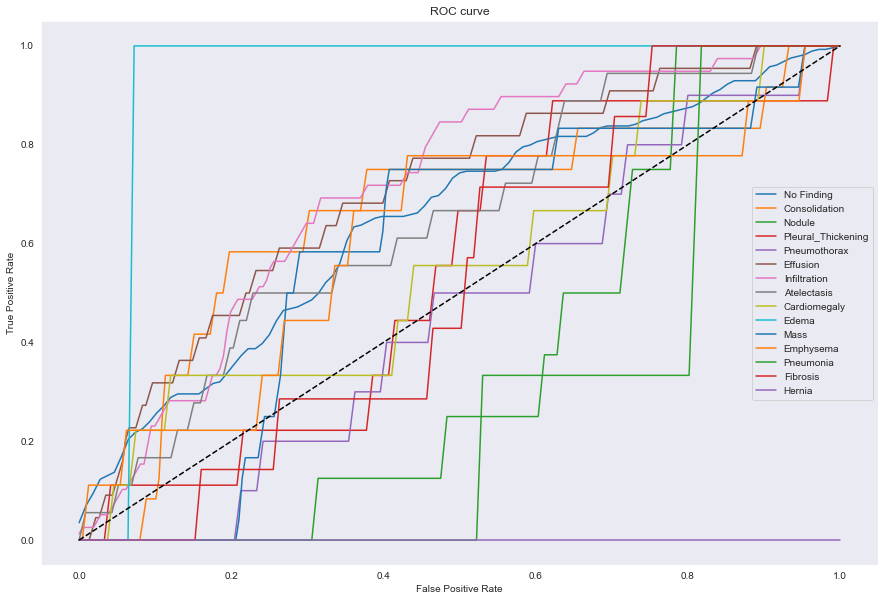

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))
#ax = ax.ravel()
b = np.linspace(0,1,num = fpr[0].shape[0])
for i in range(15):
  sns.lineplot(y = tpr[i],x = fpr[i],ci=None)
sns.lineplot(b,b,linestyle="dashed",color = 'Black')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(l)
ax.set_title('ROC curve')

#### Interpretations of the ROC curve
Looking at roc curves for the different classes it definetly does not look great for a lot of them, especially Nodule and pneumonia does not look that good. The thing that is important to realize is that some of the classes has a really low sampling rate, meaning that getting a true positive is almost imposible. One extreme case we would like to highlight is Hernia, which actually does not appear in our samples at all. For the sake of the torturial we do not resample the data-set as this is a great example of how the ROC curve actually works. The other extreme example we can look at is *Edema* whicbh has a really high TPR rate at a really low FPR rate, so what does that even mean? It means that we can actually classiy EDEMA quite well for our validation set, what will be evident later in this torturial is the importance of having a validation set which is representative. Do note that for us to do so, we are back at the sampling problem for multilabel classification data-sets. 


#### Using the ROC curve to find optimal thresholds 
Choosing the threshold will be done by finding the index that maximizes $threshold = argmax_{threshold}(TPR-FPR)$ for each of the class thresholds, meaning we will have 15 different thresholds. Note that it is important that we do this on the validation set, since we want our test set to be completely unseen by anything we do, to avoid biasing the model. So when selecting the thresholds we could think of this, as the final model optimization we will have to do. 

So what we will be doing now is to run a loop over the tpr and fpr curves we get form the torch metrics ROC object. We will subtract the two from one another, and get the index of the maximum value. Find this index by calling `torch.argmax()`, remember that we are working with tensors, and to keep everything within the same "eco-system" we should use the pytorch implementation. 

In [ ]:
thres = []
for i in range(15):
  idx = torch.argmax((tpr[i]-fpr[i])).item()
  thres.append(thresholds[i][idx].item())
thres

We see that the thresholds are quite low for most of them which is a little worrying. This is because of the fact that a low threshold means that we need to have very low thresholds to even detect each desciece, and had we chosen 50% as our cut-off point we probably would not have found any of the diseases. 

Now we define a function to give us the binary labels from the predicted thresholds, given the raw predictions. These will be used for later metrics to be calculated. 

In [ ]:
def get_bin_predictions(predictions,thresholds):
  bin_preds = torch.zeros(len(predictions),15) # placeholder 
  for i in range(len(thresholds)):
    bin_preds[:,i] = predictions[:,i] > thresholds[i]
  return bin_preds

## Testing 
Now we want to run the model on the completely new testing data. First we will load the trained weights which we provide. They are available on the github, and you can put them in you working directory. Also we will be getting both the "raw" output predictions and the binary predictions found by using the calculated thresholds from the ROC curve. 

In [ ]:
#Put in your 
predictions,labels = get_preds(model_DN,val_dataloader)

0it [00:00, ?it/s]

#### Accuracy as a metric for multilabel 
When doing classification the first thing that migh come to mind, when wanting to asses the performance of the classifier, is to use accuracy. For a data-set such as ours that might however not be a good thing. Recall that we can think of each class as a binary classification task, however for each instance we have of a discease we have even more instances where that descease is not present, so when optimizing the network it will converge towards a state where it will predict each label to be zero more often than not. 

We will be calculating accuracy using the torch metrics Accuracy object, which does take "*multilabel*" as an option. What we will also be doing is setting `accuracy=None` since we want to investigate how the classifier does on each individual label. 

In [ ]:
bin_predictions = get_bin_predictions(predictions,thres)
if device == "cuda":
  predictions = predictions.cpu()
  labels = labels.cpu()
acc = Accuracy('multilabel', num_labels=15, average=None).to("cpu")
accuracy = acc(bin_predictions,labels)
columns_data = data.columns[12:]
mapper = {}
for i in range(len(columns_data)):
  mapper.update({columns_data[i]: round(accuracy[i].item(), 5) })

# Mapper to dataframe
mapper_df = pd.DataFrame.from_dict(mapper, orient='index', columns=['Accuracy'])
display(mapper_df)

,Accuracy
No Finding,0.520
Consolidation,0.448
Nodule,0.308
Pleural_Thickening,0.608
Pneumothorax,0.872
Effusion,0.840
Infiltration,0.288
Atelectasis,0.328
Cardiomegaly,0.732
Edema,0.400


In order to give a better perspective on how these stack up against eachother we can plot it using the `sns.barplot` function. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'No Finding'),
  Text(1, 0, 'Consolidation'),
  Text(2, 0, 'Nodule'),
  Text(3, 0, 'Pleural_Thickening'),
  Text(4, 0, 'Pneumothorax'),
  Text(5, 0, 'Effusion'),
  Text(6, 0, 'Infiltration'),
  Text(7, 0, 'Atelectasis'),
  Text(8, 0, 'Cardiomegaly'),
  Text(9, 0, 'Edema'),
  Text(10, 0, 'Mass'),
  Text(11, 0, 'Emphysema'),
  Text(12, 0, 'Pneumonia'),
  Text(13, 0, 'Fibrosis'),
  Text(14, 0, 'Hernia')])

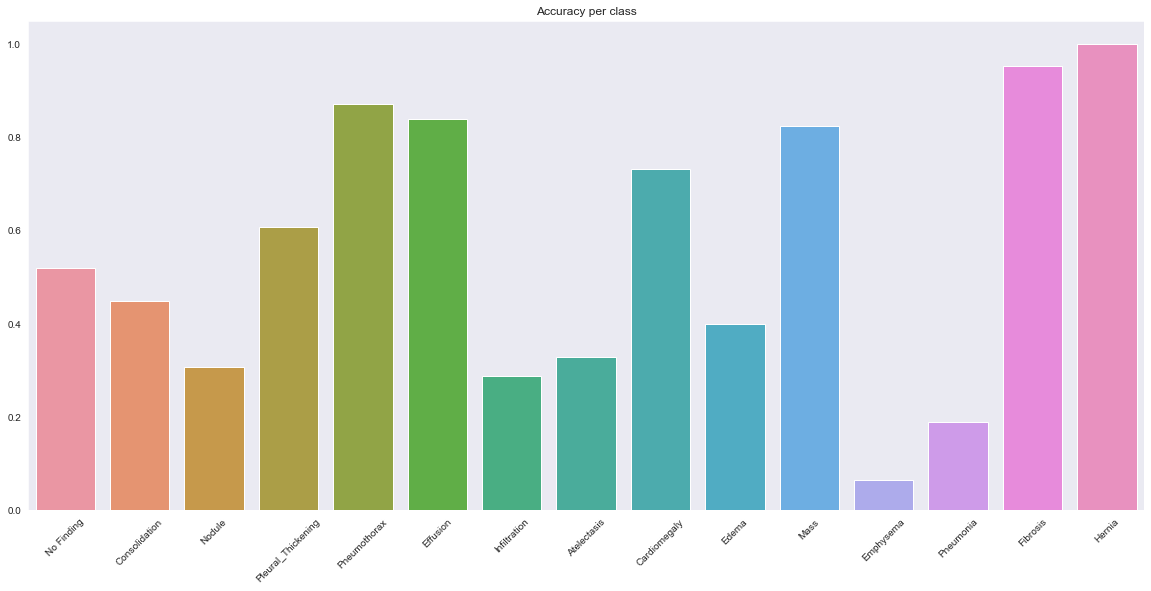

In [ ]:
# Plot accuracy
plt.rcParams["figure.figsize"] = (10*2,5*1.8)
x = list(mapper.keys())
y = list(mapper.values())
sns.barplot(x,y)
plt.title('Accuracy per class')
plt.xticks(rotation=45)

Our accuracy for this model is quite low for many of the labels. Keep in mind that this dataset was an extremely difficult dataset to work with. Not only do you have multiple classes there are overlapping classes, meaning that a single image can have multiple labels. The main issue that may lie with trying to deal with the datset is sampling it such that your sample is balanced between all labels, and you have a good amount of data for each label. However our model is slightly better than random guessing, for some labels which is a good sign. Note how our Edema label accuracy is extremely low for our test data however for our validation data it is quite high, this could be due to the low number of samples we have for this class. Another reason our model is also not that great is because our training time was extremely short. We only trained with a handful of epochs on a limited subset of the data, and in total trained for about an hour on our dataset. Hopefully you can improve on this model, and get a better accuracy. 

### Confusion matrix and F1-score 

So now we need to investigate how our classifier predicts each label, we will do this by using a confusion matrix. As we are doing multilabel classification, we need to construct an entire set of confusion matrices. The way to think of this is, at that each label is a binary classification made, and we want to investigate F1 score for each of these. In theory we could sum all of these into one metric, however this makes it really hard to see which classes are causing the most trouble, for the network. 

We can use the confmat object to find the confusion matrix for each instance. Remember that torch metrics takes cares of the multilabel classification for us in this case. 

The way we will be showcasing the confusion matrix for each label, is by looping over each class, and then plot them using sklearns `ConfusionMatrixDisplay` which will plot the confusion matrix for us. 

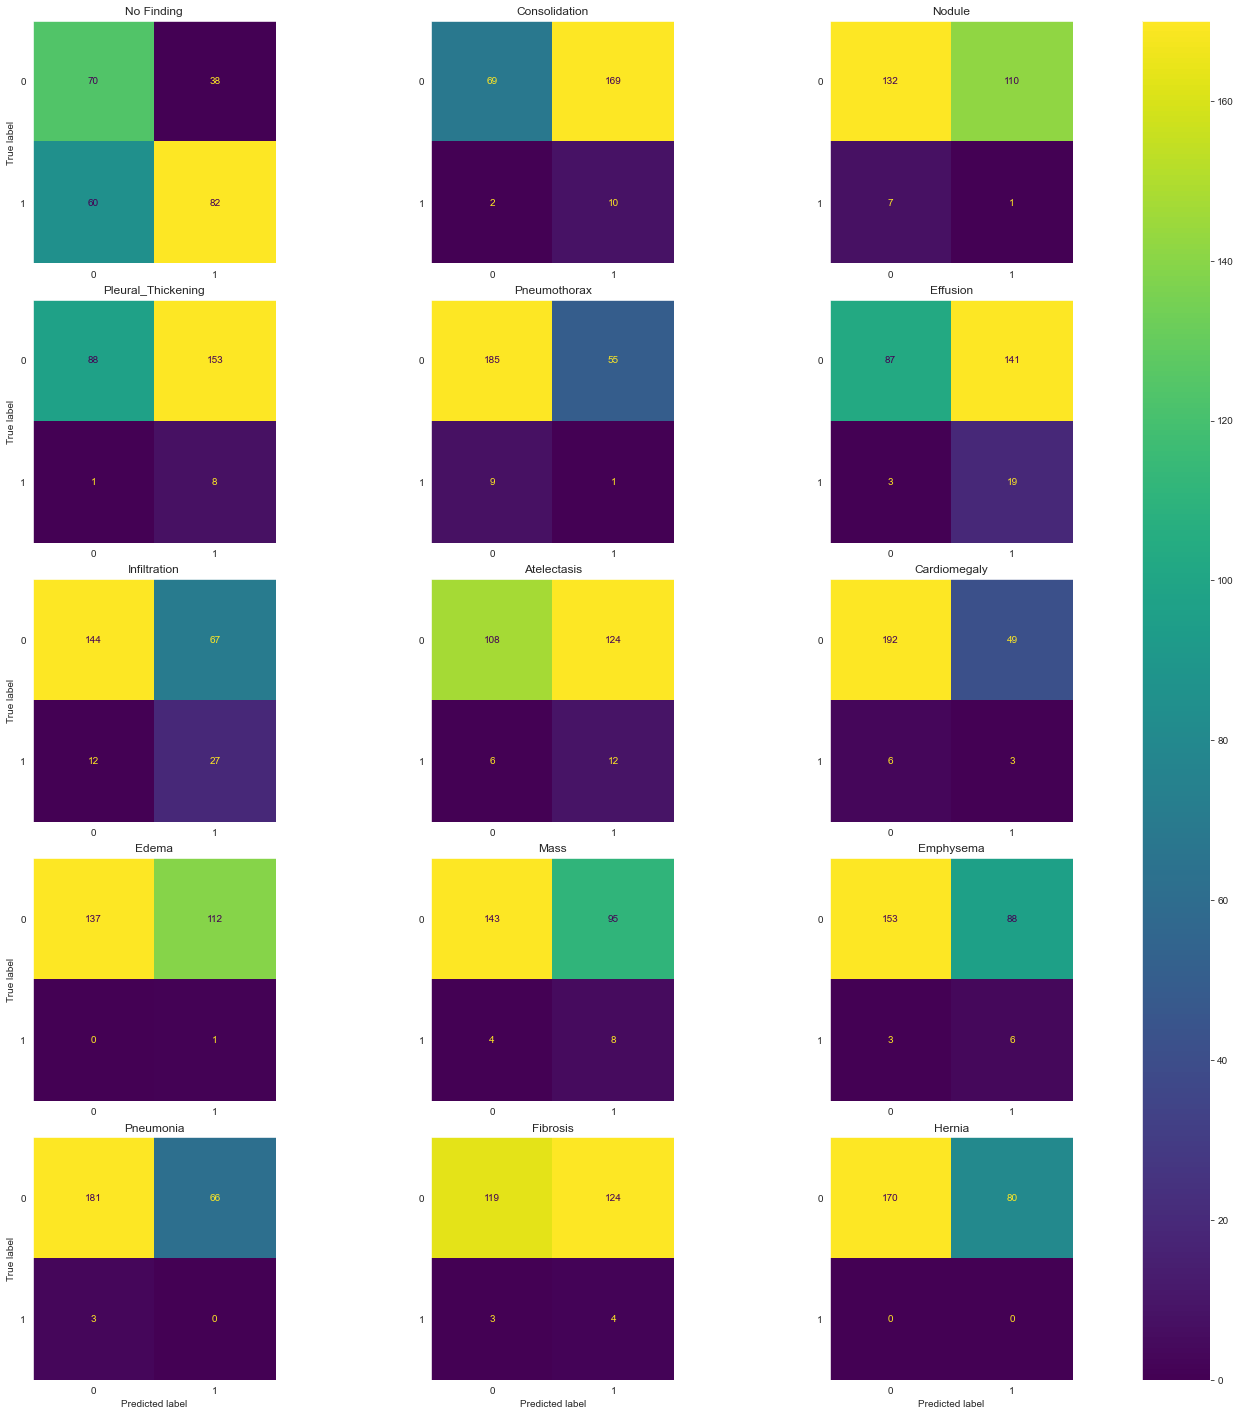

In [ ]:
cm = confmat(bin_predictions,labels.to(int)).numpy()
l = list(overview.keys())

fig, ax = plt.subplots(5,3,figsize=(25, 25))
ax = ax.ravel()
idx = 0
for i in range(15):
  d = ConfusionMatrixDisplay(cm[i])
  d.plot(ax=ax[i], values_format='.4g')

  d.ax_.set_title(l[i])
  if i<12:
    d.ax_.set_xlabel('')
  
  if i%3!=0:
    d.ax_.set_ylabel('')
  
  d.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.15)
fig.colorbar(d.im_, ax=ax)
plt.show()

So what can be interpreted for each of these results? First of that the classifier we provide does not do a good job of finding each class label, at all.

If you remember how we showed that the classifier did well on Edema in the validation set, we now see that the threshold actually might be way to low, since it is very willing to predict positive for edema, and that has resultet in a lot of false positive predictions, and even though we do find the one case of Edema, we also end up predicting 112 as Edema even though their not. 

In order to give a better overview of these confusion matrices we will use the F1 statistic, to give an better overview. We can simply call the f1 object initialized earlier, and parse the predictions and labels to the f1 score.

In [ ]:
f1(bin_predictions.to(device),labels.to(device))

tensor([0.6260, 0.1047, 0.0168, 0.0941, 0.0303, 0.2088, 0.4060, 0.1558, 0.0984,
        0.0175, 0.1391, 0.1165, 0.0000, 0.0593, 0.0000], device='cuda:0')

So if we recall how F1 score is defined: 

$F1 = 2 \times \frac{precission \times recall}{precission+recall}$

So it is a geometric mean between our abillity to find the postive samples, and how precise we are with the examples we find. Because we could easily find every single instance of every desciese by simply classifying every class as positive in every instance, but that is not desireable. 

In [ ]:
thres

[0.6027158498764038,
 0.024582581594586372,
 0.04806185141205788,
 0.02342965453863144,
 0.04113622009754181,
 0.06797090917825699,
 0.14313046634197235,
 0.07670251280069351,
 0.03425256535410881,
 0.00856711808592081,
 0.03806976601481438,
 0.028807036578655243,
 0.013711133040487766,
 0.020317092537879944,
 0.006071715150028467]

In [ ]:
overview

{'No Finding': 587,
 'Consolidation': 37,
 'Nodule': 49,
 'Pleural_Thickening': 29,
 'Pneumothorax': 38,
 'Effusion': 84,
 'Infiltration': 131,
 'Atelectasis': 99,
 'Cardiomegaly': 30,
 'Edema': 10,
 'Mass': 34,
 'Emphysema': 25,
 'Pneumonia': 10,
 'Fibrosis': 20,
 'Hernia': 4}

#Conclusions and final thoughts 
